In [27]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
#import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *

#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#from engine import train_one_epoch, evaluate


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 23.7 ms


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

time: 4.76 ms


In [3]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)

time: 3.81 ms


In [4]:
transform = transforms.ToTensor()

kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

time: 731 ms


In [5]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
def fr50_Model(pretrained = False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #true works
    # create an anchor_generator for the FPN
    # which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        #sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        sizes=tuple([(10, 15, 20, 30, 40) for _ in range(5)]),
         
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    
    
    
    model.rpn.anchor_generator = anchor_generator

    # 256 because that's the number of features that FPN returns
    model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
    return model

time: 5.47 ms


In [6]:
#check one sample from train with batch size 20
for i, (sample, old_targets, road_image, extra) in enumerate(train_data_loader): #, print_freq, header): 
        
        images = sample
        targets = trans_target(old_targets)
        #print("images len {}, targets len {}".format(len(images), len(targets)))
        #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 1.84 s


In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                 std=[0.31936955, 0.3117349 , 0.2953726 ])

tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) 

images = [tt(sew_images(s)) for s in sample] #list of [3, 800, 800], should be 1 per patch
targets = trans_target(old_targets)

time: 549 ms


In [8]:
len(targets)

5

time: 11.7 ms


In [9]:
#testmodel = fr50_Model(True)

time: 1.64 ms


In [10]:
#loss_dict = testmodel(images, targets)

time: 1.29 ms


In [11]:
#loss_dict #okay works

time: 1.19 ms


In [12]:
## try training the a model with sew images non pannorm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(False) #try False

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

time: 5.18 s


In [13]:
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [  0/479]  eta: 0:46:15  lr: 0.000100  loss: 5.5524 (5.5524)  loss_classifier: 4.7879 (4.7879)  loss_box_reg: 0.0002 (0.0002)  loss_objectness: 0.6901 (0.6901)  loss_rpn_box_reg: 0.0742 (0.0742)  time: 5.7935  data: 1.2025  max mem: 3770
Epoch: [0]  [100/479]  eta: 0:09:22  lr: 0.000100  loss: 0.9806 (1.3812)  loss_classifier: 0.1959 (0.5735)  loss_box_reg: 0.0198 (0.0152)  loss_objectness: 0.6219 (0.6623)  loss_rpn_box_reg: 0.1167 (0.1302)  time: 1.5184  data: 0.0294  max mem: 4710
Epoch: [0]  [200/479]  eta: 0:07:02  lr: 0.000100  loss: 1.0882 (1.1752)  loss_classifier: 0.3026 (0.3855)  loss_box_reg: 0.0690 (0.0232)  loss_objectness: 0.5044 (0.6115)  loss_rpn_box_reg: 0.1996 (0.1550)  time: 1.7191  data: 0.0294  max mem: 5633
Epoch: [0]  [300/479]  eta: 0:04:35  lr: 0.000100  loss: 0.7970 (1.0931)  loss_classifier: 0.1617 (0.3305)  loss_box_reg: 0.0232 (0.0310)  loss_objectness: 0.4667 (0.5709)  loss_rpn_box_reg: 0.1560 (0.1608)  time: 1.5379  data: 0.0324  max mem: 5633


Epoch: [5]  [200/479]  eta: 0:07:02  lr: 0.000010  loss: 0.9306 (0.6612)  loss_classifier: 0.2812 (0.1485)  loss_box_reg: 0.0479 (0.0225)  loss_objectness: 0.4028 (0.3711)  loss_rpn_box_reg: 0.1642 (0.1192)  time: 1.7379  data: 0.0295  max mem: 7303
Epoch: [5]  [300/479]  eta: 0:04:36  lr: 0.000010  loss: 0.7179 (0.7050)  loss_classifier: 0.1459 (0.1645)  loss_box_reg: 0.0248 (0.0288)  loss_objectness: 0.3582 (0.3828)  loss_rpn_box_reg: 0.1418 (0.1289)  time: 1.5902  data: 0.0294  max mem: 7303
Epoch: [5]  [400/479]  eta: 0:02:01  lr: 0.000010  loss: 0.7067 (0.6889)  loss_classifier: 0.1672 (0.1622)  loss_box_reg: 0.0266 (0.0282)  loss_objectness: 0.3655 (0.3808)  loss_rpn_box_reg: 0.1358 (0.1178)  time: 1.6311  data: 0.0315  max mem: 7303
Epoch: [5]  [478/479]  eta: 0:00:01  lr: 0.000010  loss: 0.6901 (0.6888)  loss_classifier: 0.1549 (0.1583)  loss_box_reg: 0.0308 (0.0271)  loss_objectness: 0.3779 (0.3822)  loss_rpn_box_reg: 0.1449 (0.1213)  time: 1.6568  data: 0.0296  max mem: 7303


Epoch: [10]  [400/479]  eta: 0:02:00  lr: 0.000000  loss: 0.6893 (0.6672)  loss_classifier: 0.1402 (0.1499)  loss_box_reg: 0.0201 (0.0237)  loss_objectness: 0.3665 (0.3779)  loss_rpn_box_reg: 0.1368 (0.1158)  time: 1.6079  data: 0.0294  max mem: 7303
Epoch: [10]  [478/479]  eta: 0:00:01  lr: 0.000000  loss: 0.6418 (0.6648)  loss_classifier: 0.1461 (0.1449)  loss_box_reg: 0.0174 (0.0226)  loss_objectness: 0.3786 (0.3790)  loss_rpn_box_reg: 0.1487 (0.1184)  time: 1.6244  data: 0.0303  max mem: 7303
Epoch: [10] Total time: 0:12:03 (1.5111 s / it)
Epoch: [11]  [  0/479]  eta: 0:23:20  lr: 0.000000  loss: 0.4833 (0.4833)  loss_classifier: 0.1087 (0.1087)  loss_box_reg: 0.0205 (0.0205)  loss_objectness: 0.3093 (0.3093)  loss_rpn_box_reg: 0.0447 (0.0447)  time: 2.9236  data: 1.4080  max mem: 7303
Epoch: [11]  [100/479]  eta: 0:09:12  lr: 0.000000  loss: 0.6081 (0.5778)  loss_classifier: 0.1507 (0.1121)  loss_box_reg: 0.0205 (0.0149)  loss_objectness: 0.3192 (0.3566)  loss_rpn_box_reg: 0.1037 

KeyboardInterrupt: 

time: 2h 58min 55s


In [14]:


torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            
            }, "../models/fastRCNN_sew614epoch.pt")

time: 624 ms


In [15]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 1.03 s


In [16]:
model.eval()
with torch.no_grad():
     prediction = model(images)

time: 670 ms


In [21]:
prediction 

[{'boxes': tensor([[613.7640, 679.2568, 663.1630, 699.0024],
          [532.9646, 694.4006, 582.8264, 713.8063],
          [358.1482, 647.7135, 407.5477, 667.7618],
          [357.7361, 631.1887, 407.6921, 650.9132],
          [277.0364, 710.9747, 326.9579, 730.8698],
          [520.1086, 710.7538, 569.8279, 730.9595],
          [549.4442, 694.4785, 599.2202, 713.5327],
          [694.0197, 646.6371, 742.7462, 666.5207],
          [199.8183, 661.8444, 248.4129, 682.3532],
          [543.1078, 708.2937, 589.2595, 727.7323],
          [487.1221, 710.5396, 536.9730, 730.5803],
          [503.6035, 710.8680, 553.5212, 731.2224],
          [643.5159, 662.5163, 693.5502, 681.8942],
          [423.5380, 646.0087, 473.4097, 666.8774],
          [644.9860, 679.5114, 694.8530, 699.1470],
          [182.9062, 646.3970, 231.9422, 666.3263],
          [390.6836, 614.3486, 440.4083, 634.3798],
          [326.1066, 679.1635, 375.1211, 698.8534],
          [471.4041, 711.2748, 521.8697, 731.4208],
   

time: 67.4 ms


In [20]:
targets[0]

{'boxes': tensor([[587.7640, 390.4039, 634.5888, 410.7347],
         [723.5701, 494.8876, 770.2949, 515.9766],
         [346.5826, 625.2436, 392.2856, 643.8907],
         [208.3556, 429.6745, 252.5559, 448.8516],
         [103.3553, 430.6902, 147.5497, 449.4175],
         [ 31.1752, 463.0602,  79.2614, 483.2730],
         [340.5685, 465.9312, 384.6458, 484.8769],
         [648.6622, 555.0985, 696.0050, 573.7671],
         [496.1005, 585.7907, 541.8034, 604.4378],
         [519.1313, 464.6352, 561.6338, 483.1805],
         [ 25.9092, 359.7119,  71.8441, 382.5251],
         [716.3273, 617.2219, 763.7090, 636.7295],
         [321.8503, 425.9930, 395.7314, 448.2401],
         [271.5695, 590.2742, 317.2724, 608.9213],
         [384.5264, 589.7536, 430.2294, 608.4007],
         [ 66.1751, 394.0988, 110.3829, 413.8457],
         [256.3764, 392.4210, 300.9099, 411.0828],
         [692.8306, 459.0505, 740.1176, 481.0863],
         [504.9691, 550.0915, 550.6720, 568.7386],
         [ 16.2913, 43

time: 73 ms


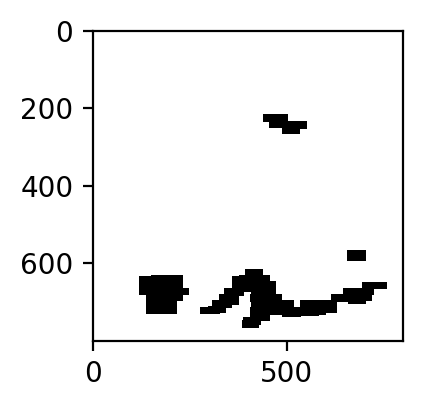

time: 416 ms


In [35]:
#plot prediction
 
road_img = gen_result_chart(prediction [0])
fig, ax = plt.subplots(figsize=(2, 3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

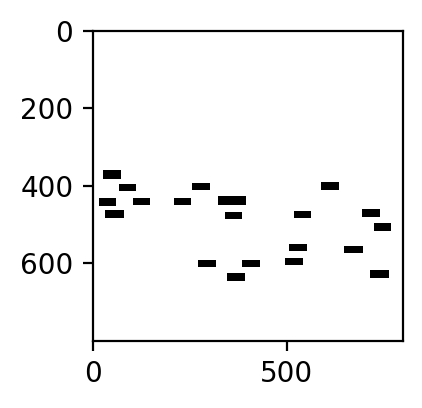

time: 379 ms


In [36]:
#plot targets
 
road_img = gen_result_chart(targets [0])
fig, ax = plt.subplots(figsize = (2,3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

In [37]:
#do another one
for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if i == 1:
            break

time: 1.08 s


In [38]:
model.eval()
with torch.no_grad():
     prediction2 = model(images)

time: 74.1 ms


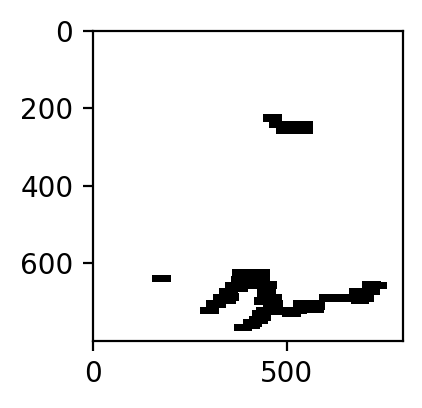

time: 584 ms


In [39]:
road_img = gen_result_chart(prediction2 [0])
fig, ax = plt.subplots(figsize=(2, 3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

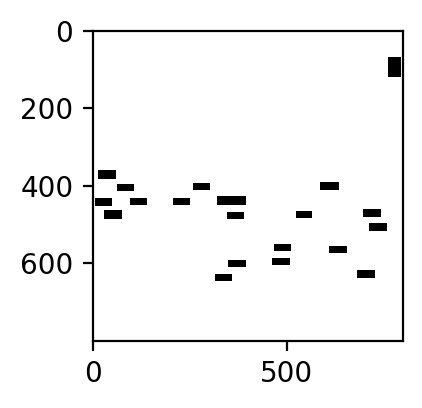

time: 472 ms


In [40]:
road_img = gen_result_chart(targets [0])
fig, ax = plt.subplots(figsize = (2,3))
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')